In [1]:
import os

data_folder = "g:/BreastUltrasoundSegm"
segmentation_file_name = "_segmentation.npy"

In [2]:
import numpy as np

segmentation_file = os.path.join(data_folder, segmentation_file_name)

print(f"Loading {segmentation_file}...")

# Load data file as numpy array
data = np.load(segmentation_file)

print(f"Shape of segmentation data: {data.shape}")
print(f"    Value range: {np.min(data)} - {np.max(data)}")
print(f"    Data type: {data.dtype}")

Loading g:/BreastUltrasoundSegm\_segmentation.npy...
Shape of segmentation data: (1803, 615, 525, 1)
    Value range: 0 - 1
    Data type: uint8


In [6]:
indices_file_name = segmentation_file_name.replace("_segmentation", "_indices")
indices_file = os.path.join(data_folder, indices_file_name)

print(f"Loading {indices_file}...")

# Load data file as numpy array
indices = np.load(indices_file)

print(f"Shape of indices data: {indices.shape}")
print(f"    Value range: {np.min(indices)} - {np.max(indices)}")
print(f"    Data type: {indices.dtype}")



Loading g:/BreastUltrasoundSegm\_indices.npy...
Shape of indices data: (17,)
    Value range: 46 - 356
    Data type: int32


In [ ]:
transform_file_name = segmentation_file_name.replace("_segmentation", "_transform")
transform_file = os.path.join(data_folder, transform_file_name)

print(f"Loading {transform_file}...")
transform = np.load(transform_file)

print(f"Shape of transform data: {transform.shape}")
print(f"    Data type: {transform.dtype}")

In [7]:
ultrasound_file_name = segmentation_file_name.replace("_segmentation", "_ultrasound")
ultrasound_file = os.path.join(data_folder, ultrasound_file_name)
ultrasound = np.load(ultrasound_file)

print(f"Shape of ultrasound data: {ultrasound.shape}")
print(f"    Value range: {np.min(ultrasound)} - {np.max(ultrasound)}")
print(f"    Data type: {ultrasound.dtype}")

Shape of ultrasound data: (1803, 615, 525, 1)
    Value range: 0 - 247
    Data type: uint8


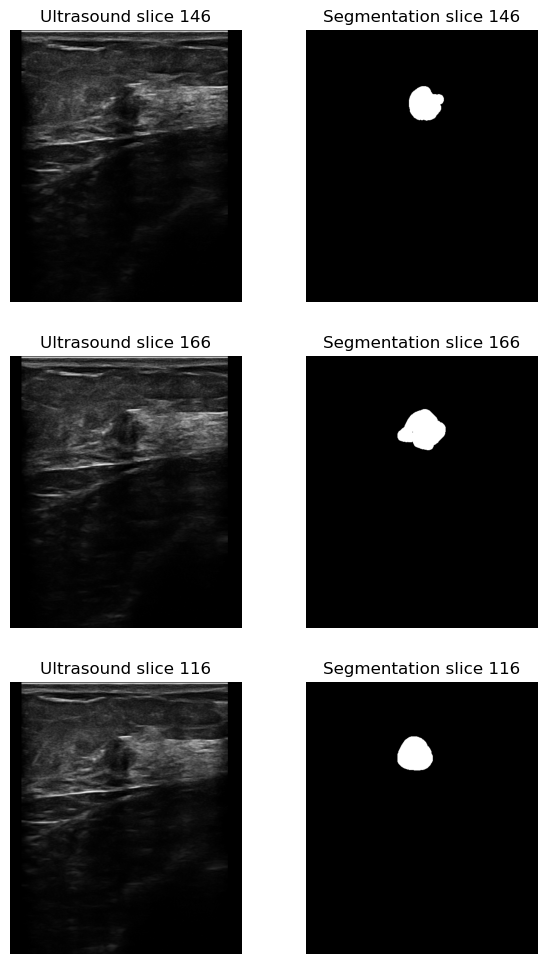

In [8]:
# Show five random slices of ultrasound and segmentation data side by side. Only pick slices whose indices are in the indices file.

import random
import matplotlib.pyplot as plt

num_random_slices = 3

# Pick random slice numbers from the indices
random_slices = random.sample(list(indices), num_random_slices)

# Create a figure with num_random_slices rows and 2 columns
fig, axes = plt.subplots(num_random_slices, 2, figsize=(7, num_random_slices * 4))

# Loop over all slices
for i, slice_index in enumerate(random_slices):
    # Get the ultrasound and segmentation data for the slice
    ultrasound_slice = ultrasound[slice_index, :, :, 0]
    segmentation_slice = data[slice_index, :, :]

    # Plot the ultrasound data
    axes[i, 0].imshow(ultrasound_slice, cmap="gray")
    axes[i, 0].set_title(f"Ultrasound slice {slice_index}")
    axes[i, 0].axis("off")


    # Plot the segmentation data
    axes[i, 1].imshow(segmentation_slice, cmap="gray")
    axes[i, 1].set_title(f"Segmentation slice {slice_index}")
    axes[i, 1].axis("off")

plt.show()


Slice index: 1610
Shape of ultrasound slice: (615, 525, 1)
Shape of segmentation slice: (615, 525, 1)


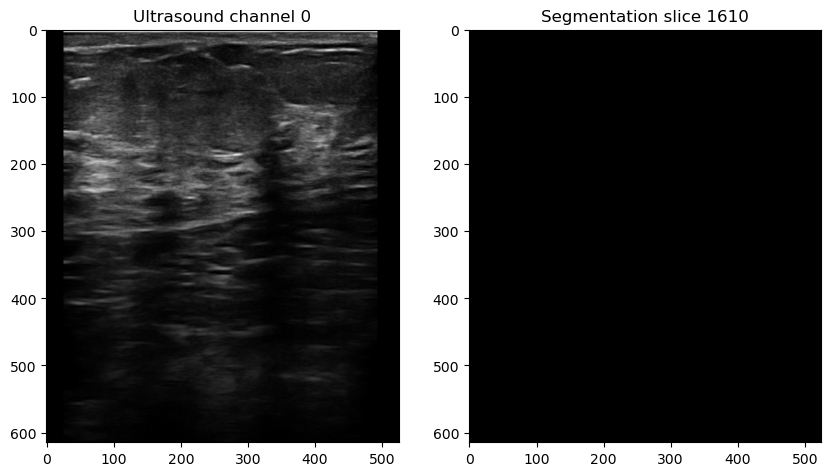

In [9]:
# Show one random slice of ultrasound and segmentation data side by side. Show all channels of ultrasound image as separate images.

import random
import matplotlib.pyplot as plt

# Pick one random slice
slice_index = random.randint(0, data.shape[0])
print(f"Slice index: {slice_index}")

# Get the ultrasound and segmentation data for the slice
ultrasound_slice = ultrasound[slice_index, :, :, :]
segmentation_slice = data[slice_index, :, :]
print(f"Shape of ultrasound slice: {ultrasound_slice.shape}")
print(f"Shape of segmentation slice: {segmentation_slice.shape}")

num_channels = ultrasound_slice.shape[2]

# Create a figure with 1 row and num_channels + 1 columns
fig, axes = plt.subplots(1, num_channels + 1, figsize=(10, 10))

# Plot the ultrasound data
for i in range(num_channels):
    axes[i].imshow(ultrasound_slice[:, :, i], cmap="gray")
    axes[i].set_title(f"Ultrasound channel {i}")

# Plot the segmentation data
axes[num_channels].imshow(segmentation_slice, cmap="gray")
axes[num_channels].set_title(f"Segmentation slice {slice_index}")

plt.show()